In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, concatenate
import keras
from keras.models import Sequential
from keras.layers import  GlobalAveragePooling2D, Conv2D, MaxPooling2D, Dense, Flatten
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from tqdm import tqdm
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

import tensorflow as tf
 
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2

from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tensorflow.keras.utils import to_categorical



Poster prediction

In [ ]:
from keras.models import load_model

poster_model = load_model(filepath='C:/Users/poppp/CGVR/poster_model.h5')
poster_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [ ]:
#poster predict
poster = []

def poster_predict(g):
    
    train_df = pd.read_csv('C:/Users/poppp/CGVR/train_df2.csv')

    img = image.load_img('C:/Users/poppp/CGVR/poster/'+ str(g) +'.jpg' ,target_size=(224,224,3))
    img = image.img_to_array(img)
    img = img/255
    classes = np.array(train_df.columns[2:])
    proba = poster_model.predict(img.reshape(1,224,224,3))
    top_3 = np.argsort(proba[0])[:-4:-1]
    #print('예측 장르')
    for j in range(3):
        print("{}".format(classes[top_3[j]])+" ({:.3})".format(proba[0][top_3[j]]))
    
    poster.append(proba)
    
    poster_model.layers[-1].activation = None
    #activation map
    def get_img_array(img_path, size):
        # `img` is a PIL image of size 299x299
        img = keras.preprocessing.image.load_img(img_path, target_size=size)
        # `array` is a float32 Numpy array of shape (299, 299, 3)
        array = keras.preprocessing.image.img_to_array(img)
        # We add a dimension to transform our array into a "batch"
        # of size (1, 299, 299, 3)
        array = np.expand_dims(array, axis=0)
        return array


    def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
        # First, we create a model that maps the input image to the activations
        # of the last conv layer as well as the output predictions
        grad_model = tf.keras.models.Model(
            [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
        )

        # Then, we compute the gradient of the top predicted class for our input image
        # with respect to the activations of the last conv layer
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(img_array)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]

        # This is the gradient of the output neuron (top predicted or chosen)
        # with regard to the output feature map of the last conv layer
        grads = tape.gradient(class_channel, last_conv_layer_output)

        # This is a vector where each entry is the mean intensity of the gradient
        # over a specific feature map channel
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        # We multiply each channel in the feature map array
        # by "how important this channel is" with regard to the top predicted class
        # then sum all the channels to obtain the heatmap class activation
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        # For visualization purpose, we will also normalize the heatmap between 0 & 1
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        return heatmap.numpy()
    
    def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.7):
        # Load the original image
        img = keras.preprocessing.image.load_img(img_path)
        img = keras.preprocessing.image.img_to_array(img)

        # Rescale heatmap to a range 0-255
        heatmap = np.uint8(255 * heatmap)

        # Use jet colormap to colorize heatmap
        jet = cm.get_cmap("jet")

        # Use RGB values of the colormap
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

        # Create an image with RGB colorized heatmap
        jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

        # Superimpose the heatmap on original image
        superimposed_img = jet_heatmap * alpha + img
        superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

        # Save the superimposed image
        superimposed_img.save(cam_path)

        # Display Grad CAM
        display(Image(cam_path))
        
        
    img_size = (224, 224)
    preprocess_input = keras.applications.xception.preprocess_input

    last_conv_layer_name = "conv2d_4"    
        
    img_path = 'C:/Users/poppp/CGVR/poster/' + str(g) +'.jpg'
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, poster_model, last_conv_layer_name)
    save_and_display_gradcam(img_path, heatmap)
    
    

        
        

스릴러 (0.489)
공포 (0.468)
액션 (0.0211)


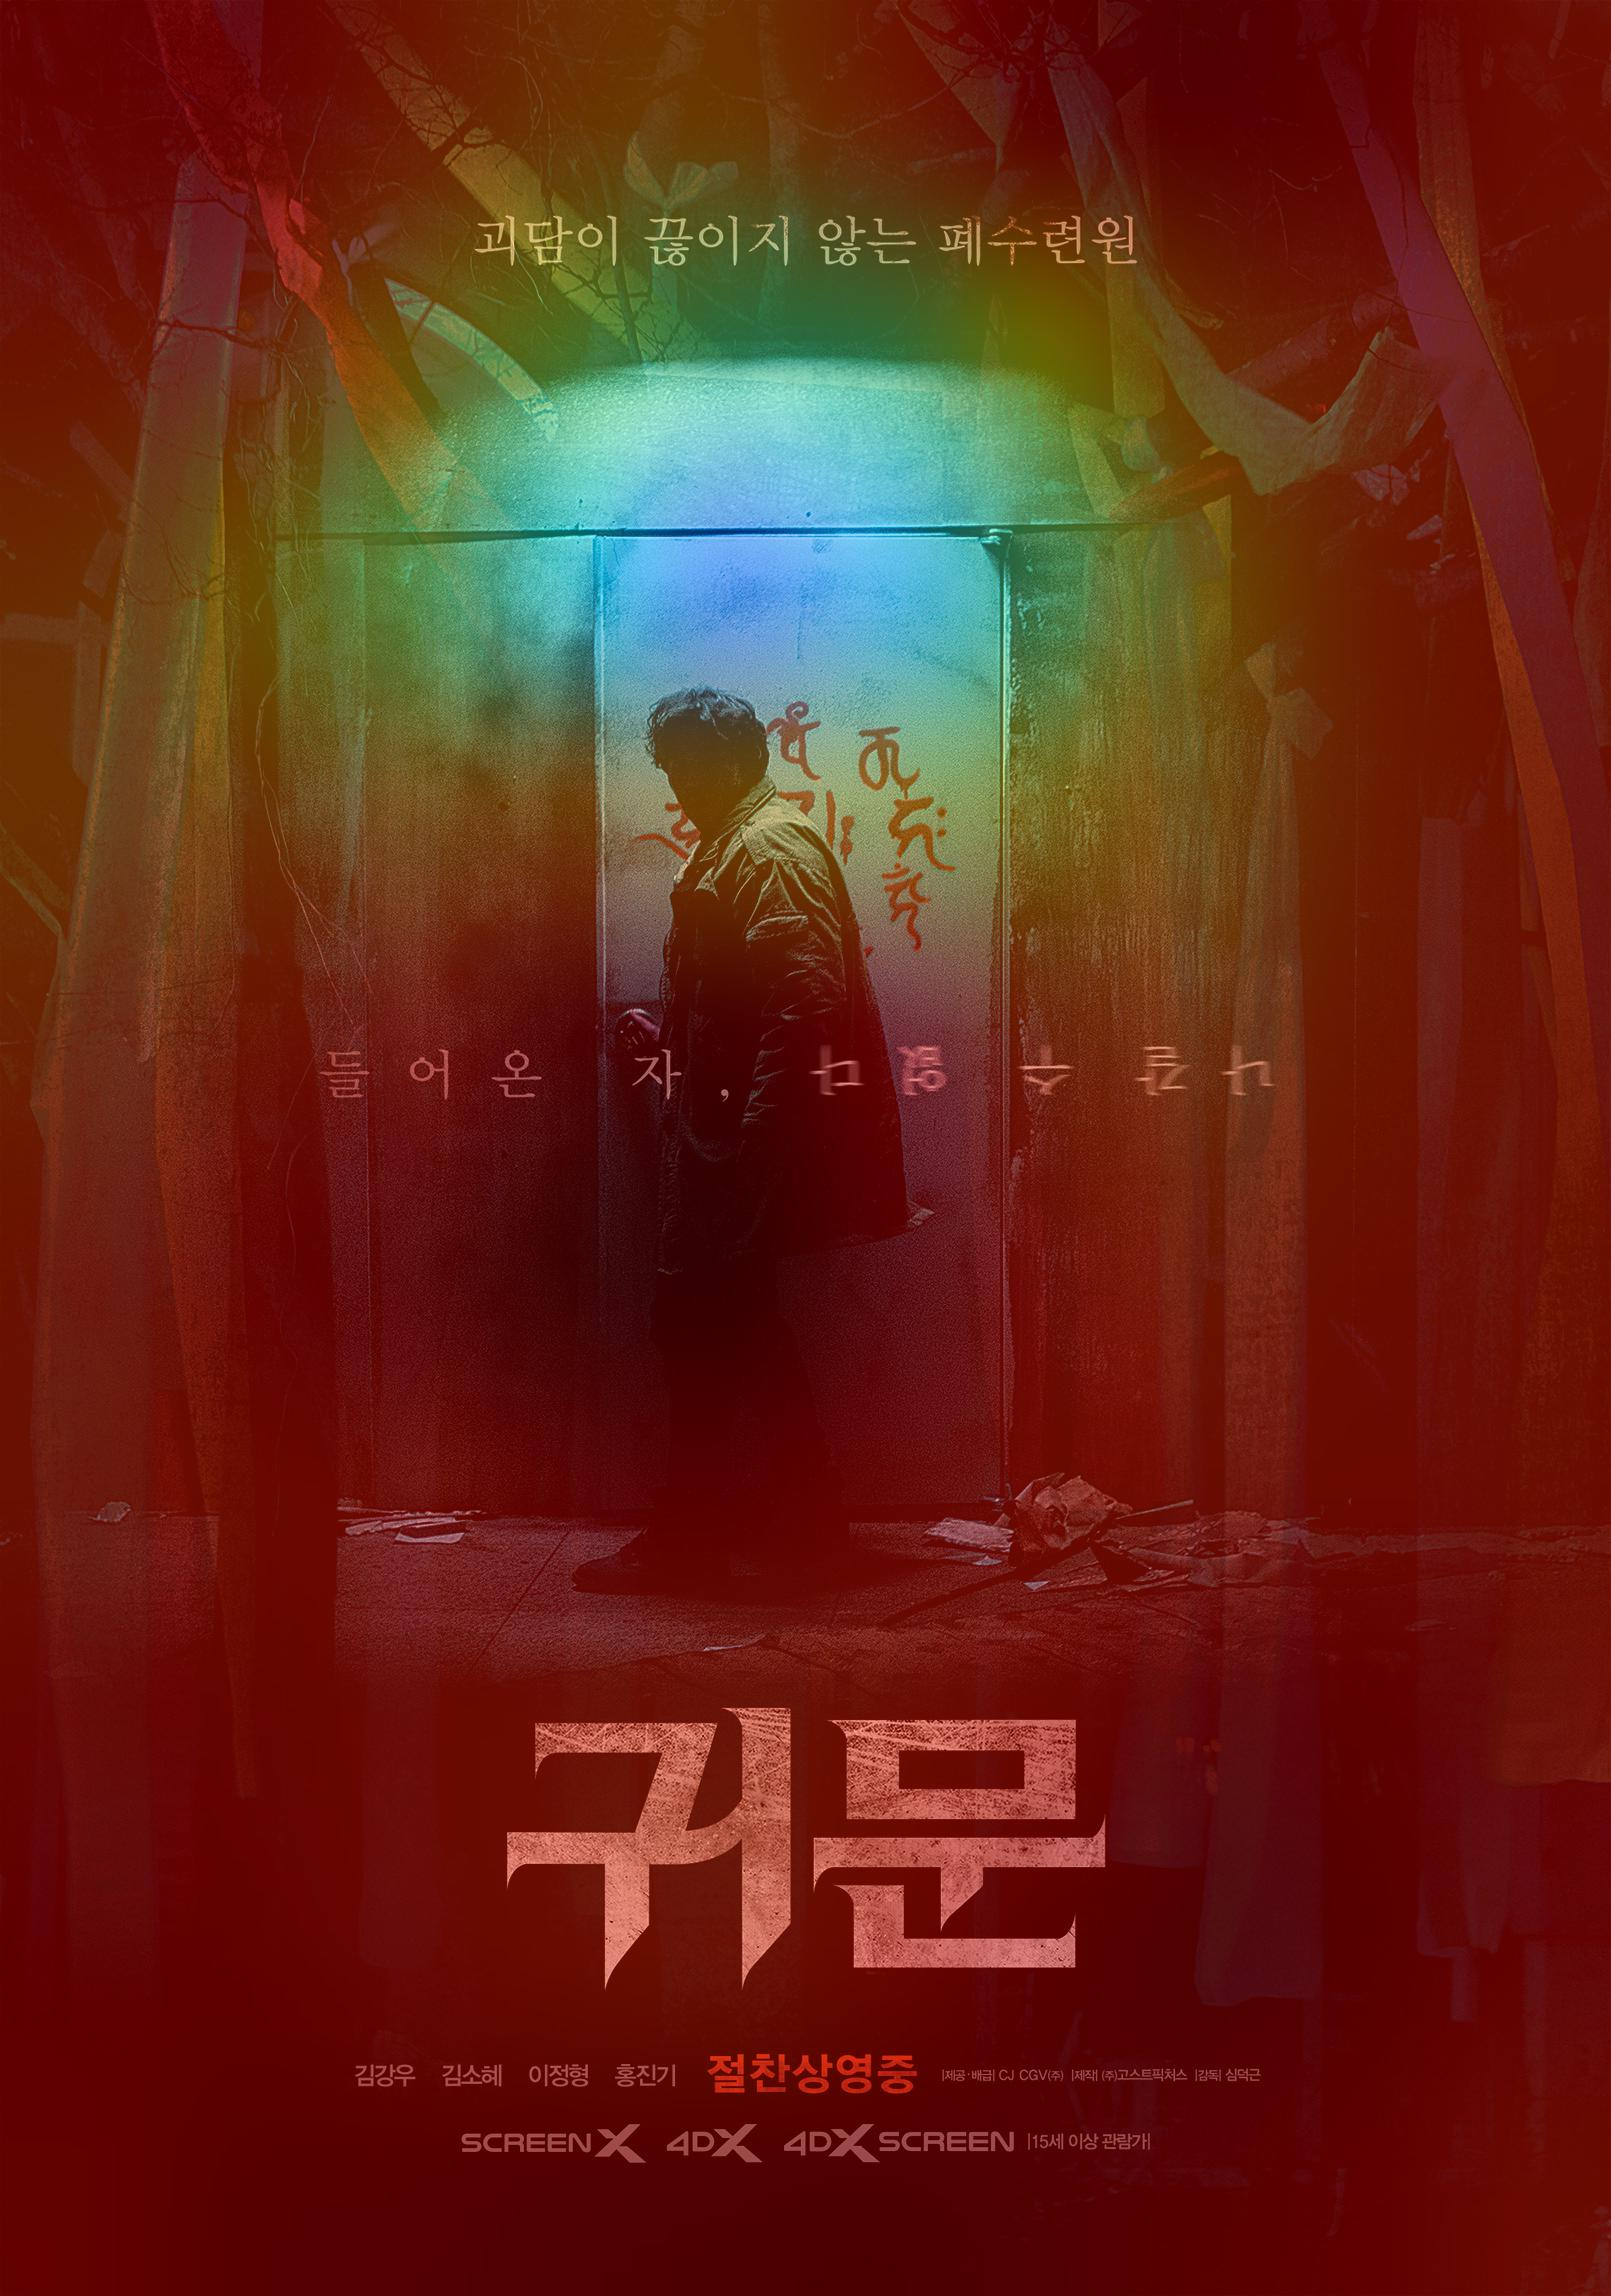

In [ ]:
poster_predict(206168)

In [ ]:
poster

[array([[0.00794434, 0.1281008 , 0.06097372, 0.02017697, 0.16103265,
         0.6217715 ]], dtype=float32)]

Poster writing prediction

In [ ]:
df_all = pd.read_csv('ocr_data.csv')

In [ ]:
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
okt = Okt()
tokenizer = Tokenizer()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','영화','연기']

In [ ]:
X_train = []
for sentence in tqdm(df_all['sen']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 4286/4286 [00:05<00:00, 795.35it/s] 


In [ ]:
random = df_all['sen'].sample(800, random_state=123).index.tolist()
dfs = df_all.iloc[random]
dfs

,sen,genre
2144,모처럼,2
565,휴일,0
3746,코메디,5
2858,조폭 마누라,4
2363,직설,3
...,...,...
2153,설레임,2
3237,불효자,4
1340,조이다,1
3595,규칙도 모른다 기술도 없 다 매 너 도 더 럽 다 크하핫 반칙왕이 나가신다...,5


In [ ]:
X_test = []
for sentence in tqdm(dfs['sen']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 800/800 [00:00<00:00, 1678.52it/s]


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)



단어 집합(vocabulary)의 크기 : 4113
등장 빈도가 2번 이하인 희귀 단어의 수: 2616
단어 집합에서 희귀 단어의 비율: 63.60320933625091
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 23.8780245276765


In [ ]:
vocab_size = 4000

tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

y_train = np.array(df_all['genre'])
y_test = np.array(dfs['genre'])

In [ ]:
max_len = 16

In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 128
hidden_units = 128
num_classes = 6

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train, y_train, batch_size=64, epochs=100, callbacks=[es, mc], validation_data=(X_test, y_test))

Epoch 1/100
67/67 [==============================] - ETA: 0s - loss: 1.7893 - acc: 0.1731
Epoch 1: val_acc improved from -inf to 0.22125, saving model to best_model.h5
67/67 [==============================] - 4s 26ms/step - loss: 1.7893 - acc: 0.1731 - val_loss: 1.7614 - val_acc: 0.2212
Epoch 2/100
66/67 [============================>.] - ETA: 0s - loss: 1.7149 - acc: 0.2495
Epoch 2: val_acc improved from 0.22125 to 0.45125, saving model to best_model.h5
67/67 [==============================] - 1s 19ms/step - loss: 1.7154 - acc: 0.2492 - val_loss: 1.5914 - val_acc: 0.4512
Epoch 3/100
66/67 [============================>.] - ETA: 0s - loss: 1.4880 - acc: 0.4411
Epoch 3: val_acc improved from 0.45125 to 0.57375, saving model to best_model.h5
67/67 [==============================] - 1s 17ms/step - loss: 1.4865 - acc: 0.4431 - val_loss: 1.1763 - val_acc: 0.5738
Epoch 4/100
67/67 [==============================] - ETA: 0s - loss: 1.1096 - acc: 0.5499
Epoch 4: val_acc improved from 0.57375 t

In [ ]:
from keras.models import load_model, save_model
loaded_model = load_model('C:\\Users\\poppp\\CGVR\\best_model.h5')


In [ ]:
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

25/25 [==============================] - 0s 3ms/step - loss: 0.7099 - acc: 0.6687

 테스트 정확도: 0.6687


In [ ]:
import pandas as pd
import os.path

#Poster writing predict
def ocr_predict(g):
    
    path = 'C://Users//poppp//CGVR/OCR/'+ str(g)  + '.txt'

    file = open(path, "r", encoding = "utf-8")
    strings = file.readlines()
    strings = list(map(lambda s: s.strip(), strings))
    strings = (' '.join(strings))
    
    def r_predict(g, new_sentence):
        new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
        new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
        new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
        encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩

        predict = loaded_model.predict(encoded)
        #score = float(loaded_model.predict(encoded)) # 예측
        ocr.append(predict)
        #predict = np.concatenate(predict).tolist()
        genre = np.argmax(predict) 
        top = np.argsort(predict)
        top = np.concatenate(top).tolist()
        top = top[:-4:-1]
        #print(top)
        reviews = []


        for i in top:
            if i == 0:
                #print('로맨스')
                reviews.append('로맨스')
            if i == 1:
                #print('공포')
                reviews.append('공포')
            if i == 2:
                #print('드라마')
                reviews.append('드라마')
            if i == 3:
                #print('스릴러')
                reviews.append('스릴러')
            if i == 4:
                #print('액션')
                reviews.append('액션')
            if i == 5:
                #print('코미디')
                reviews.append('코미디')

    r_predict(g, strings)

In [ ]:
ocr = []
poster = []
results = []

In [ ]:
ocr_predict(120513)

Review prediction

In [ ]:
review_model = Word2Vec.load('review_model')

In [ ]:
w = pd.read_csv('C://Users//poppp//CGVR/word.csv')

In [ ]:
def review_predict(g):
    
    path = 'C://Users//poppp//CGVR/review/review_'+ str(g)  + '.txt'

    file = open(path, "r", encoding = "utf-8")
    strings = file.readlines()
    strings = list(map(lambda s: s.strip(), strings))
    strings = (' '.join(strings))

    drama = [0]
    romance = [0]
    horror = [0]
    thriller = [0]
    action = [0]
    comedy = [0]
    
    
    def v_predict(g,new_sentence):

        new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
        new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
        new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거


        for j in w['genre'][:21]:
            for i in new_sentence:
                try:
                    predict = review_model.wv.similarity(j,i)# 예측
                    if predict > 0.5:
                        romance.append(predict)
                except KeyError:
                    continue

        for j in w['genre'][21:42]:
            for i in new_sentence:
                try:
                    predict = review_model.wv.similarity(j,i)# 예측
                    if predict > 0.5:
                        horror.append(predict)
                except KeyError:
                    continue  

        for j in w['genre'][63:84]:
            for i in new_sentence:
                try:
                    predict = review_model.wv.similarity(j,i)# 예측
                    if predict > 0.5:
                        drama.append(predict)
                except KeyError:
                    continue  

        for j in w['genre'][84:105]:
            for i in new_sentence:
                try:
                    predict = review_model.wv.similarity(j,i)# 예측
                    if predict > 0.5:
                        thriller.append(predict)
                except KeyError:
                    continue  

        for j in w['genre'][105:126]:
            for i in new_sentence:
                try:
                    predict = review_model.wv.similarity(j,i)# 예측
                    if predict > 0.5:
                        action.append(predict)
                except KeyError:
                    continue  

        for j in w['genre'][126:147]:
            for i in new_sentence:
                try:
                    predict = review_model.wv.similarity(j,i)# 예측
                    if predict > 0.5:
                        comedy.append(predict)
                except KeyError:
                    continue  


        romance_result = np.sum(romance)/len(romance)
        results.append(romance_result)

        horror_result = np.sum(horror)/len(horror)
        results.append(horror_result)


        drama_result = np.sum(drama)/len(drama)
        results.append(drama_result)

        thriller_result = np.sum(thriller)/len(thriller)
        results.append(thriller_result)

        action_result = np.sum(action)/len(action)
        results.append(action_result)

        comedy_result = np.sum(comedy)/len(comedy)
        results.append(comedy_result)


        #print(results)

        genre = np.argmax(results) 
        genre

        top = np.argsort(results)[:-4:-1]
        #print(top)
        reviews = []

        for i in top:
            if i == 0:
                #print('로맨스')
                reviews.append('로맨스')
            if i == 1:
                #print('공포')
                reviews.append('공포')
            if i == 2:
                #print('드라마')
                reviews.append('드라마')
            if i == 3:
                #print('스릴러')
                reviews.append('스릴러')
            if i == 4:
                #print('액션')
                reviews.append('액션')
            if i == 5:
                #print('코미디')
                reviews.append('코미디')
                
    v_predict(g,strings)
    

In [ ]:
review_predict(81891)

Genre prediction

In [ ]:
#모든 네트워크 합치기
def op_predict(g):
    
    ocr_predict(g)
    poster_predict(g)
    review_predict(g)


    ocr2 = np.array(ocr).flatten().tolist()
    poster2 = np.array(poster).flatten().tolist()
    print(poster2)
    print(results)
    print(ocr2)
    add_list = [(poster2[i] + ocr2[i] + results[i]) / 3 for i in range(6)] 
    print(add_list)
    top = np.argsort(add_list)[:-3:-1]
    for i in top:
        if i == 0:
            print('로맨스')
        if i == 1:
            print('공포')
        if i == 2:
            print('드라마')
        if i == 3:
            print('스릴러')
        if i == 4:
            print('액션')
        if i == 5:
            print('코미디')    

 103381


드라마 (0.305)
코미디 (0.237)
액션 (0.194)


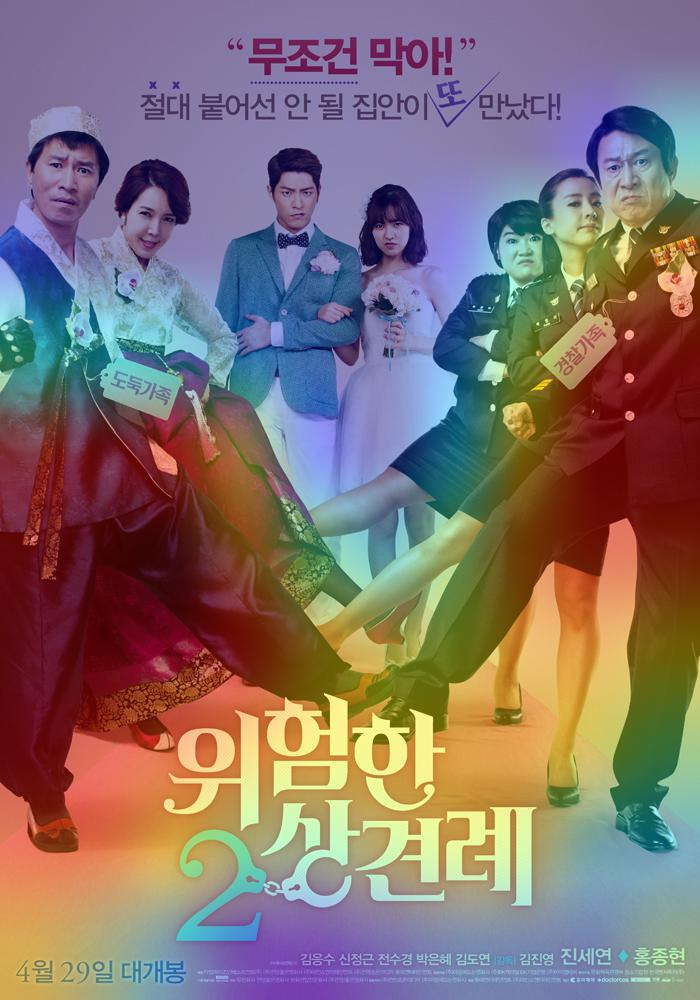

[0.03505448251962662, 0.3054733872413635, 0.1397833526134491, 0.08952749520540237, 0.19355833530426025, 0.23660296201705933]
[0.5805917293614795, 0.5539156695550701, 0.5738634017765832, 0.5594031625836935, 0.560982255026316, 0.5843570485939019]
[0.008273503743112087, 0.006741214543581009, 0.04826044291257858, 0.10490179061889648, 0.4209674894809723, 0.4108555316925049]
[0.20797323854140606, 0.28871009044667156, 0.253969065767537, 0.2512774828026641, 0.3918360266038496, 0.4106051807678221]
코미디
액션


In [ ]:
#실행하기
ocr = []
poster = []
results = []
code = int(input())
op_predict(code)

 145414


코미디 (0.319)
액션 (0.251)
드라마 (0.243)


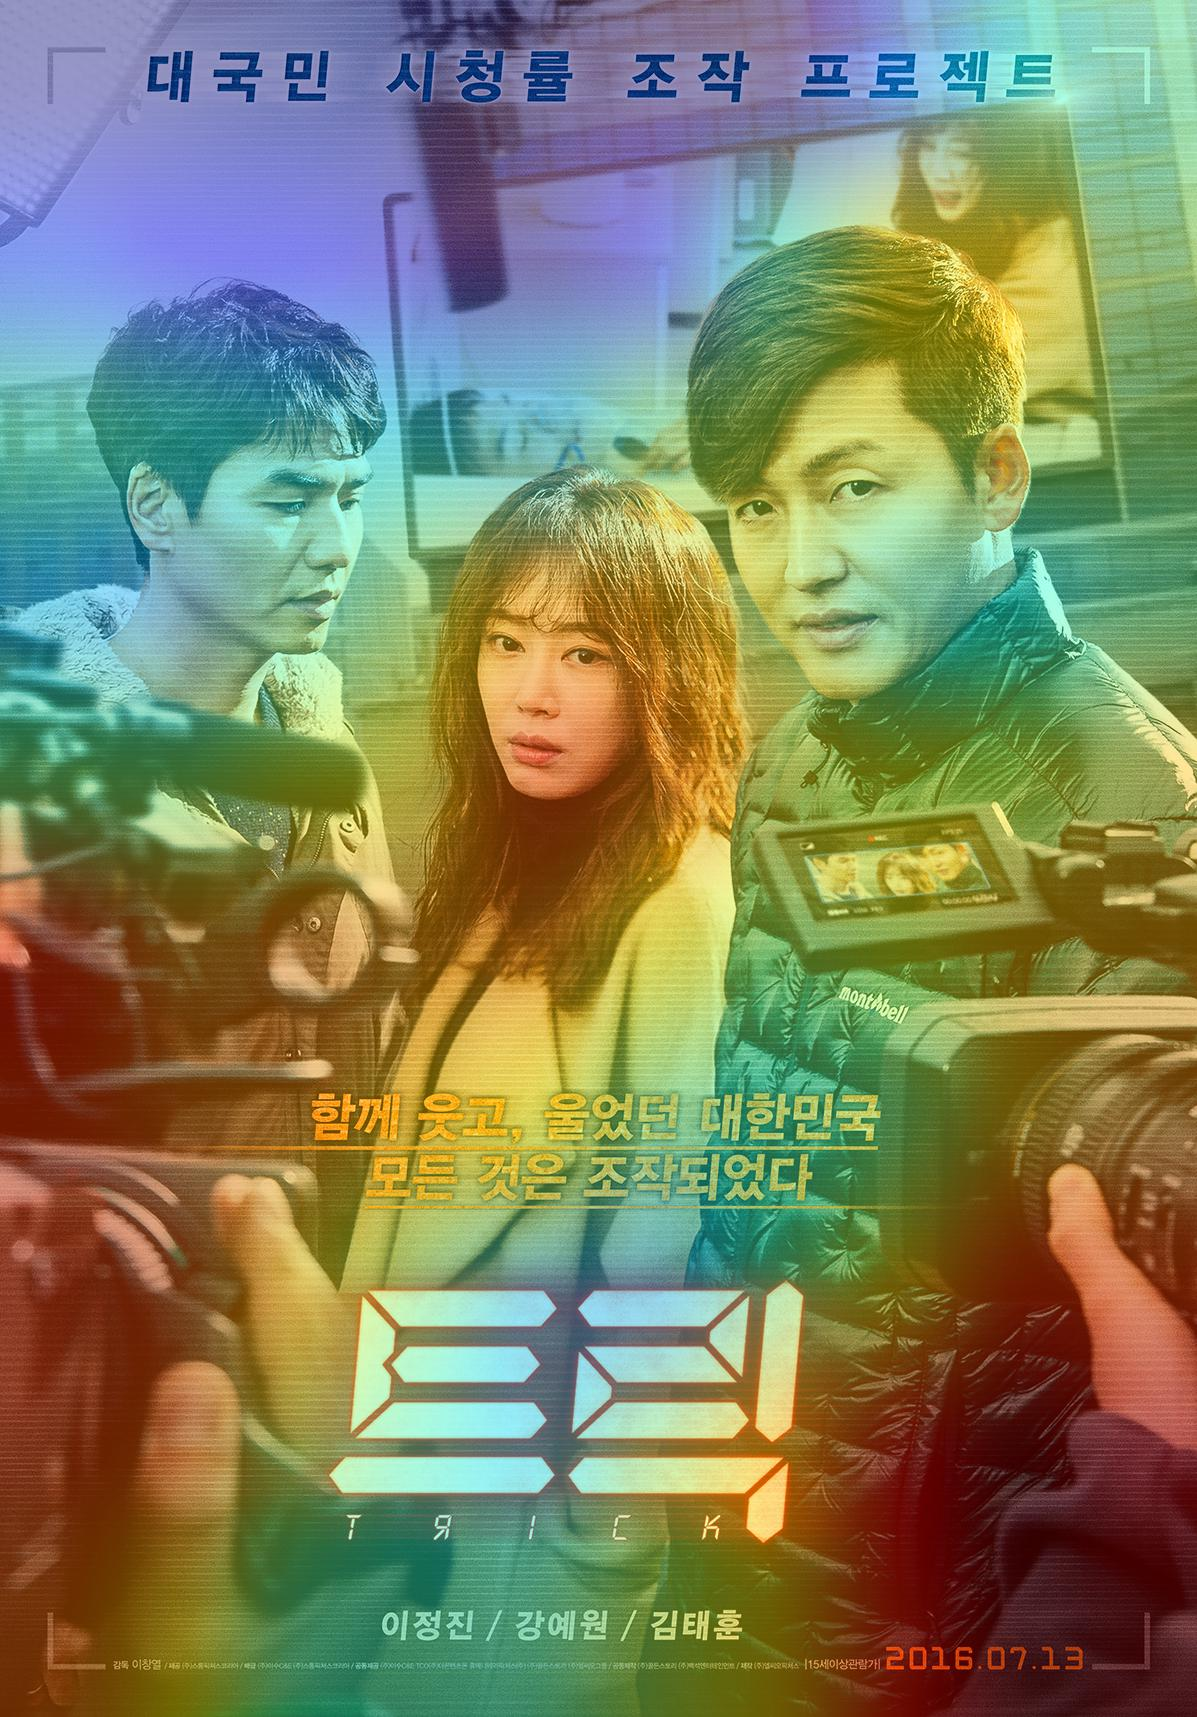

[0.026873620226979256, 0.2433299422264099, 0.08850158751010895, 0.07081693410873413, 0.2513025999069214, 0.31917527318000793]
[0.1889303978325592, 0.2731790555739209, 0.23078631233496993, 0.2295181060438616, 0.42595978842841253, 0.4522202933828036]
코미디
액션


In [ ]:
ocr = []
poster = []
results = []
code = int(input())
op_predict(code)